[Baseline Model](#baseline_model)<br>
[Baseline Score Evaluation](#baseline_score)<br>
[Grid Search Evaluation](#grid_search_evaluation)<br>
[Polynomial Features](#polynomial_features)<br>
[Polynomial Features Evaluation](#polynomial_features_evaluation)<br>
[Neural Network](#neural_network)<br>
[Classification](#classification)<br>
[Classification Scores](#classification_scores)<br>

# Predicting  Accident Location with Accident Data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
accidents_df = pd.read_csv('./Data/smaller_csv.csv')

## BaseLine <a id='baseline_model'><a>

In [71]:
#Checking out the Dtypes
accidents_df.dtypes

ID                        object
Source                    object
TMC                      float64
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
Distance(mi)             float64
Description               object
Side                      object
Weather_Timestamp         object
Temperature(F)           float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity                     bool
Bump                        bool
Crossing                    bool
Give_Way                    bool
Junction                    bool
No_Exit                     bool
Railway                     bool
Roundabout                  bool
Station                     bool
Stop                        bool
Traffic_Ca

In [58]:
# The baseline model will be off of bool's ints, and floats
X = accidents_df[['Severity', 'Distance(mi)', 'Temperature(F)', 
                     'Humidity(%)',  'Pressure(in)', 'Visibility(mi)',
                     'Wind_Speed(mph)',  'Precipitation(in)', 'Amenity',
                     'Bump', 'Crossing', 'Give_Way',
                     'Junction', 'No_Exit', 'Railway', 
                     'Roundabout', 'Station', 'Stop', 
                     'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Start_Lat', 'Start_Lng']]
y = accidents_df[['Start_Lat', 'Start_Lng']]

In [59]:
#This fixes a really weird error that occurs later if it's not here
X.dropna(inplace = True)

C:\Users\Jonathan\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
# This also fixes an error that occurs later if it's not here
X = X.astype(float)

<AxesSubplot:>

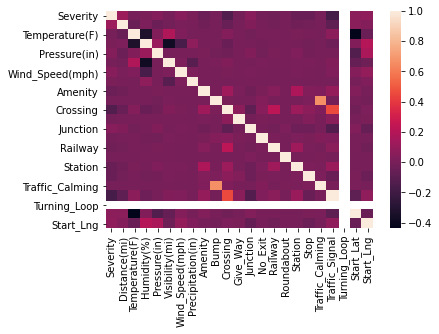

In [61]:
#Checking out association for Start_Lat and Start_Lng
sns.heatmap(X.corr())

In [62]:
# complete lack of association between Temperature and latitude as well as really weird variance with Turning_Loop
X.drop(['Turning_Loop', 'Temperature(F)'], axis = 1, inplace = True)

<AxesSubplot:>

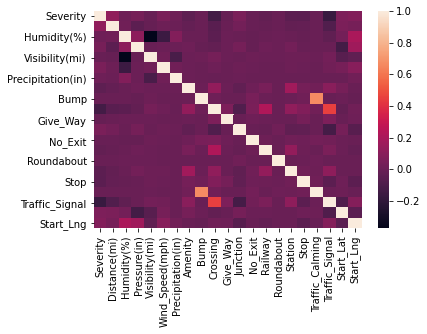

In [63]:
#Checking out New Associations, might look into removing Visibility or Humidity later
sns.heatmap(X.corr())

In [64]:
X.drop(['Start_Lat', 'Start_Lng'], axis = 1, inplace = True)

In [65]:
#Scaling data for Ridge regression and later classification models
ss = StandardScaler()
X_ss = ss.fit_transform(X)

In [66]:
# Quick train test split
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, train_size = .8, random_state = 42)

In [67]:
# Fitting the models
linreg = LinearRegression().fit(X_train, y_train)
lasso = Lasso().fit(X_train, y_train)
ridge = Ridge().fit(X_train, y_train)

In [41]:
# Quick accuracy score to see validity as a predictor
print(f'Accuracy Score = {lasso.score(X_test, y_test)}')
print(f'Accuracy Score = {linreg.score(X_test, y_test)}')
print(f'Accuracy Score = {ridge.score(X_test, y_test)}')

Accuracy Score = 0.03686422158865793
Accuracy Score = 0.06978106345738216
Accuracy Score = 0.06978106746972901


In [42]:
# Getting predictions for to find r2 score mse and lasso
pred = linreg.predict(X_test)
lasso_pred = lasso.predict(X_test)
ridge_pred = ridge.predict(X_test)

In [43]:
print(f'r2_score = {metrics.r2_score(pred, y_test)}')
print(f'Mean Squared Error = {metrics.mean_squared_error(pred, y_test)}')
print(f'lasso r2_score = {metrics.r2_score(lasso_pred, y_test)}')
print(f'lasso Mean Squared Error = {metrics.mean_squared_error(lasso_pred, y_test)}')
print(f'ridge r2_score = {metrics.r2_score(ridge_pred, y_test)}')
print(f'ridge Mean Squared Error = {metrics.mean_squared_error(ridge_pred, y_test)}')

r2_score = -15.43210905776574
Mean Squared Error = 145.69641506334824
lasso r2_score = -8.022566169693013e+21
lasso Mean Squared Error = 149.992403194773
ridge r2_score = -15.432165389221037
ridge Mean Squared Error = 145.69641375773082


### Base R Squared and Mean Squared Error scores <a id='baseline_score'><a> 
R squared scores are completely awful, the lasso, ridge, and linear regression lines being made by the models are completely missing the mark if there even is any mark possible to hit. Mean Squared error is also very high for what it should be and is completely unable to predict the model as it stands right now

In [44]:
# Lets Try a Gridsearch to see if it can do any better, only testing seperate alphas
param_grid = [{
    'alpha': [1.0, .1, .01, 10, 100]
}]
grid = GridSearchCV(lasso, param_grid, cv = 5)
ridge_grid = GridSearchCV(ridge, param_grid, cv = 5)

In [45]:
# Checking out the Grid Search
grid.fit(X_train, y_train)
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid=[{'alpha': [1.0, 0.1, 0.01, 10, 100]}])

In [54]:
grid_pred = grid.predict(X_test)
ridge_grid_pred = ridge_grid.predict(X_test)

In [55]:
print(f'Lasso Grid r2_score = {metrics.r2_score(grid_pred, y_test)}')
print(f'Lasso Grid Mean Squared Error = {metrics.mean_squared_error(grid_pred, y_test)}')
print(f'Ridge Grid r2_score = {metrics.r2_score(ridge_grid_pred, y_test)}')
print(f'Ridge Grid Mean Squared Error = {metrics.mean_squared_error(ridge_grid_pred, y_test)}')

Lasso Grid r2_score = -16.200181022045136
Lasso Grid Mean Squared Error = 145.6939521404101
Ridge Grid r2_score = -15.43774260142888
Ridge Grid Mean Squared Error = 145.69628511302287


In [53]:
print(f'Lasso Grid best score = {grid.best_score_}')
print(f'ridge_grid.best_score_ = {ridge_grid.best_score_}')

Lasso Grid best score = 0.07004538965854565
ridge_grid.best_score_ = 0.07006690172241475


### Grid Search Evaluation <a id='grid_search_evaluation'><a> 
Grid Search is equally inaccurate for the R Squared score and the Mean Squared error so the model is not predicting well based on the data currently inside of it and is not an issue with the alpha. The issue might be with the lack of useful data predicting Data and as such Polynomial features might be able to increase the complexity to solve what the current information is missing. 

### Polynomial Features <a id='polynomial_features'><a> 
Creating basic polynomial features then testing simple linear regression. The goal would be that added complexity increases the ability of the model to pick up on things the simplistic model missed.

In [56]:
X_2 = pd.DataFrame(PolynomialFeatures(degree = 2).fit_transform(X))
linreg_2 = LinearRegression().fit(X_2, y)
linreg_2.score(X_2, y)
lasso_2 = Lasso().fit(X_2, y)
ridge_2 = Ridge().fit(X_2, y)

In [69]:
pred_2 = linreg_2.predict(X_2)
lasso_pred_2 = lasso_2.predict(X_2)
ridge_pred_2 = ridge_2.predict(X_2)

In [70]:
print(f'Polynomial Linear Regression r2_score = {metrics.r2_score(pred_2, y)}') 
print(f'Polynomial Linear Regression Mean Squared Error = {metrics.mean_squared_error(pred_2, y)}')
print(f'Polynomial Lasso r2_score = {metrics.r2_score(lasso_pred_2, y)}')
print(f'Polynomial Lasso Mean Squared Error = {metrics.mean_squared_error(lasso_pred_2, y)}')
print(f'Polynomial Ridge r2_score = {metrics.r2_score(ridge_pred_2, y)}')
print(f'Polynomial Ridge Mean Squared Error = {metrics.mean_squared_error(ridge_pred_2, y)}')

Polynomial Linear Regression r2_score = -10.386350521481647
Polynomial Linear Regression Mean Squared Error = 142.0684533662467
Polynomial Lasso r2_score = -15.852061068382605
Polynomial Lasso Mean Squared Error = 143.73164197330263
Polynomial Ridge r2_score = -10.410445826440725
Polynomial Ridge Mean Squared Error = 142.07101383303652


### Polynomial Evaluation <a id='polynomial_feature_evaluation'><a> classification_scores 
The scores are slightly better but equally unusable. The r2 score got slightly closer to zero which is good but it may just be to overfitting, as well as the Mean Squared Error going down but it is probably aslo just from overfitting. This is a good upgrade and may be a way to evaluate this dataset but we would have to check with a train and test set

## Neural Network <a id='neural_network'><a> 
Trying to fit a large neural network in order to see if we can get the data to solve itself for this problem

In [ ]:
ss = StandardScaler()

In [ ]:
X = accidents_df.drop(['ID', 'Source', 'Side', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
                       'Description', 'Weather_Timestamp', 'Civil_Twilight', 'Nautical_Twilight', 
                       'Astronomical_Twilight', 'Sunrise_Sunset', 'TMC'], axis = 1)
y = accidents_df[['Start_Lat', 'Start_Lng']]

In [ ]:
ss.fit(X[['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']])
X[['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
   'Wind_Speed(mph)', 'Precipitation(in)']] = ss.transform(X[['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
                                                            'Wind_Speed(mph)', 'Precipitation(in)']])

In [ ]:
def model_func(neurons, dropout):
  model = Sequential()
  input_dim = X.shape[1]
  model.add(Dense(neurons, input_dim = input_dim, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation = 'linear'))

  model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae', 'accuracy'])
  return model

params = {
    "neurons": [5, 10, 20, 50, 75],
    "dropout": [.1, .3, .5]
}
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5,
                          verbose = 1, mode = 'auto', restore_best_weights = True)

nn = KerasRegressor(build_fn = model_func, epochs = 100, batch_size = 512, verbose = 1)

### Classification by State <a id='classification'><a> 
Due to the failure of the latitude and longitude predictions we will be trying to classify the data by state instead as a predictor of which states tend to have reasonably fixable accidents. 

In [62]:
location_data = pd.read_csv('./Data/location_data.csv')

In [63]:
location_data.head()

,Unnamed: 0,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Hour,Month
0,2425777,A-2425896,MapQuest,201.0,2,2017-12-12 05:57:15,2017-12-12 06:26:23,40.760189,-74.051147,0.000,...,False,False,True,False,Night,Night,Night,Day,5,12
1,655588,A-655616,MapQuest,201.0,2,2020-10-21 09:33:48,2020-10-21 10:33:53,38.073662,-117.091148,0.000,...,False,False,False,False,Day,Day,Day,Day,9,10
2,956002,A-956096,MapQuest,201.0,2,2020-02-17 10:46:23,2020-02-17 14:01:31,35.080902,-80.850151,0.000,...,False,False,True,False,Day,Day,Day,Day,10,2
3,3704728,A-3714725,Bing,201.0,2,2020-02-05 20:26:00,2020-02-05 21:18:01,34.145360,-117.280718,0.000,...,False,False,False,False,Night,Night,Night,Night,20,2
4,3097811,A-3103204,Bing,201.0,2,2020-11-24 01:23:00,2020-11-24 03:47:04,37.851172,-122.299278,0.902,...,False,False,False,False,Night,Night,Night,Night,1,11


In [64]:
# Changing our target variable
y = location_data['State']

In [65]:
# Trying to split the data into meaningful categories in order to help with state prediction
km = KMeans(50)

In [66]:
km.fit(X_ss)

KMeans(n_clusters=50)

In [67]:
# managing the shape of the dataframe to be placed into models
labels = km.labels_
labels = np.reshape(labels, (743563, 1))
X_ss = np.append(X_ss, labels, axis = 1)

In [70]:
# Resetting our train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [72]:

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [73]:
logreg.score(X_test, y_test)

0.22086599136052848

In [74]:
knn = KNeighborsClassifier(n_neighbors = 50)

In [75]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [76]:
knn.score(X_test, y_test)

0.21147339032013385

## Classification Scores <a id='classification_scores'><a>
Classification has been mostly a failure at the state level with how low the scores are for knn and logreg and I think the best way to deal with this dataset would be a neural network to try to find associations between the data that our current model is missing.